# 158.739 Introduction to Analytics Assignment 3
### by Qianying Wu (Momo) 18041217

# Introduction
This assignment is about data persistence and data analysis by using SQLite.

## Processes:
1. Dataframes preparation
2. Data persistence
3. Access data from databases
4. Data analysis
5. Database views

## Import of packages

In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import datetime
import sqlite3
import seaborn as sns

# Dataframes Preparation
There are 6 dataframes that need to prepare: 
- Residential Consumption dataframe
- Population dataframe
- Electricity Generation dataframe
- Geothermal Production dataframe
- Wind Production dataframe
- Rainfall index dataframe

In [2]:
# Residential consumption table
df=pd.read_csv('../datasets/Residential_consumption.csv',skiprows=10)
residential_consumption=df.pivot_table(values=['Est. total consumption (GWh)','Average consumption (kWh)'],index=['Region description'],aggfunc='mean')

# Population table
url = "https://en.wikipedia.org/wiki/Regions_of_New_Zealand"
response = requests.get(url)
scraping_html_table = BeautifulSoup(response.content, "lxml") 
scraping_html_table = scraping_html_table.find_all("table", "wikitable")
df2 = pd.read_html(str(scraping_html_table))
first_table_df = df2[0]
first_table_df.columns = first_table_df.iloc[0]
first_table_df = first_table_df.iloc[2:]
population_df=first_table_df[['Region name(name in Māori if different)','Population[22]']]
population_df.columns=['Region description','Population']
population_df['Region description'].replace({"Auckland(1)Tāmaki-makau-rau": "Auckland", "Bay of PlentyTe Moana-a-Toi": "Bay of Plenty",
                                            "Gisborne(1)(2)Te Tai Rāwhiti":"Gisborne","Hawke's BayTe Matau-a-Māui":"Hawke's Bay",
                                            "WellingtonTe Whanga-nui-a-Tara":"Wellington","Tasman(1)Te Tai-o-Aorere":"Tasman",
                                            "Nelson(1)Whakatū":"Nelson","Marlborough(1)Te Tauihu-o-te-waka":"Marlborough",
                                            "West CoastTe Tai Poutini":"West Coast","CanterburyWaitaha":"Canterbury",
                                            "OtagoŌtākou":"Otago","SouthlandMurihiku":"Southland"}, inplace=True)
population_df=population_df.set_index('Region description')

# Electricity Generation table
df=pd.read_excel('../datasets/Electricity.xlsx',sheet_name='Table 2',skiprows=8,nrows=12).dropna()
df=df.transpose()
df=df.rename(columns=df.iloc[0])
gov_table=df.iloc[1:]
gov_table.columns=['Net_Generation(GWh)','Hydro','Geothermal','Biogas','Wood','Wind','Solar','Oil','Coal','Gas','Waste Heat']
gov_table=gov_table.drop('Annual % change').astype('float')
gov_table=gov_table.drop('2020P')

# Geothermal Production, Wind Production, Rainfall index tables
def web_scraping(url):
    response=requests.get(url)
    page=response.content
    scraping=BeautifulSoup(page,"lxml")
    table=scraping.find_all('table',attrs={'class':'knoema-table'})
    df=pd.read_html(str(table))
    return df[0].set_index('Date')

rainfall=web_scraping("https://knoema.com/atlas/New-Zealand/topics/Water/Precipitation/National-rainfall-index")
geothermal_production=web_scraping("https://knoema.com/atlas/New-Zealand/topics/Energy/Electricity/Geothermal-electricity-net-generation")
wind_production=web_scraping("https://knoema.com/atlas/New-Zealand/topics/Energy/Electricity/Wind-electricity-net-generation")

D:\Anaconda3\lib\site-packages\pandas\core\generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [3]:
residential_consumption.head(1)

,Average consumption (kWh),Est. total consumption (GWh)
Region description,,
Auckland,7171.9,3666.3934


In [4]:
population_df.head(1)

,Population
Region description,
Auckland,1717500


In [5]:
gov_table.head(1)

,Net_Generation(GWh),Hydro,Geothermal,Biogas,Wood,Wind,Solar,Oil,Coal,Gas,Waste Heat
1974,20175.816,15037.0,1358.0,7.596,306.14,0.0,0.0,1943.0,1297.0,208.65,18.43


In [6]:
rainfall.head(1)

,Value,"Change, %"
Date,,
2017,1154,0.00 %


In [7]:
geothermal_production.head(1)

,Value,"Change, %"
Date,,
2019,7.44,-0.99 %


In [8]:
wind_production.head(1)

,Value,"Change, %"
Date,,
2019,2.22,8.55 %


In [9]:
print(residential_consumption.info())
print(population_df.info())
print(gov_table.info())
print(rainfall.info())
print(geothermal_production.info())
print(wind_production.info())

<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, Auckland to West Coast
Data columns (total 2 columns):
Average consumption (kWh)       16 non-null float64
Est. total consumption (GWh)    16 non-null float64
dtypes: float64(2)
memory usage: 384.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, Auckland to Southland
Data columns (total 1 columns):
Population    15 non-null object
dtypes: object(1)
memory usage: 240.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Index: 46 entries, 1974 to 2019
Data columns (total 11 columns):
Net_Generation(GWh)    46 non-null float64
Hydro                  46 non-null float64
Geothermal             46 non-null float64
Biogas                 46 non-null float64
Wood                   46 non-null float64
Wind                   46 non-null float64
Solar                  46 non-null float64
Oil                    46 non-null float64
Coal                   46 non-null float64
Gas                    46 non-null float64
Waste 

# Data Persistence
## Design a suitable schema for each dataframe and populate it

In [10]:
connection=sqlite3.connect('../datasets/mySQLiteDB.db3')
cursor=connection.cursor()

### For residential consumption table

In [11]:
#build a schema for residential consumption table
cursor.execute('DROP TABLE IF EXISTS RESIDENTIAL_CONSUMPTION')
residential_consump = """
            CREATE TABLE RESIDENTIAL_CONSUMPTION (
            REGION TEXT NOT NULL PRIMARY KEY,
            AVERAGE_CONSUMPTION REAL NOT NULL,
            TOTAL_CONSUMPTION REAL NOT NULL
            );
            """
cursor.execute(residential_consump)

add_residential_entry = """
            INSERT INTO RESIDENTIAL_CONSUMPTION
            (REGION, AVERAGE_CONSUMPTION, TOTAL_CONSUMPTION)
            VALUES (?,?,?)
            """
for index,row in residential_consumption.iterrows():
    substitution_values = (str(index),row['Average consumption (kWh)'],row['Est. total consumption (GWh)'])
    cursor.execute(add_residential_entry,substitution_values)
connection.commit()

In [12]:
#check
sql_statement='SELECT * FROM RESIDENTIAL_CONSUMPTION;'
cursor.execute(sql_statement)
for (REGION,AVERAGE_CONSUMPTION,TOTAL_CONSUMPTION) in cursor:
    print(REGION,AVERAGE_CONSUMPTION,TOTAL_CONSUMPTION)

Auckland 7171.9 3666.3934
Bay of Plenty 6684.9 790.6301
Canterbury 8597.8 2048.1624
Gisborne 6432.4 99.40369999999999
Hawke's Bay 7239.9 471.6363
Manawatu-Wanganui 6416.3 629.5778
Marlborough 7171.8 152.27389999999997
Nelson 7070.1 146.8615
Northland 6304.2 453.2955
Otago 8128.5 768.3619
Southland 8597.0 348.8646
Taranaki 6327.7 301.15309999999994
Tasman 7324.6 141.4188
Waikato 6837.7 1248.3641
Wellington 7149.2 1390.7633
West Coast 6044.8 89.23150000000001


### For population table

In [13]:
#build a schema for population table
cursor.execute('DROP TABLE IF EXISTS POPULATION')
population_table = """
            CREATE TABLE POPULATION (
            REGION TEXT NOT NULL,
            POPULATION INTEGER NOT NULL,
            FOREIGN KEY(REGION) REFERENCES RESIDENTIAL_CONSUMPTION(REGION)
            );  
            """
cursor.execute(population_table)

add_population_entry = """
            INSERT INTO POPULATION
            (REGION, POPULATION)
            VALUES (?,?)
            """
for index,row in population_df.iterrows():
    substitution_values = (str(index),row['Population'])
    cursor.execute(add_population_entry,substitution_values)
connection.commit()

In [14]:
#check
sql_statement='SELECT * FROM POPULATION;'
cursor.execute(sql_statement)
for (REGION,POPULATION) in cursor:
    print(REGION,POPULATION)

Auckland 1717500
Waikato 496700
Bay of Plenty 337300
Gisborne 50700
Hawke's Bay 178600
Taranaki 124600
Manawatū-Whanganui 254300
Wellington 542000
Tasman 56400
Nelson 54600
Marlborough 50200
West Coast 32400
Canterbury 645900
Otago 245300
Southland 102600


### For electricity generation table

In [15]:
#build a schema for electricity generation table
cursor.execute('DROP TABLE IF EXISTS ELE_GENERATION')
generation_table = """
            CREATE TABLE ELE_GENERATION (
            YEAR YEAR NOT NULL PRIMARY KEY,
            NET_GENERATION REAL NOT NULL,
            HYDRO REAL NOT NULL,
            GEOTHERMAL REAL NOT NULL,
            BIOGAS REAL NOT NULL,
            WOOD REAL NOT NULL,
            WIND REAL NOT NULL,
            SOLAR REAL NOT NULL,
            OIL REAL NOT NULL,
            COAL REAL NOT NULL,
            GAS REAL NOT NULL,
            WASTE_HEAT REAL NOT NULL 
            );  
            """
cursor.execute(generation_table)

add_generation_entry = """
            INSERT INTO ELE_GENERATION
            (YEAR, NET_GENERATION, HYDRO, GEOTHERMAL, BIOGAS, WOOD, WIND, SOLAR, OIL, COAL, GAS, WASTE_HEAT)
            VALUES (?,?,?,?,?,?,?,?,?,?,?,?)
            """
for index,row in gov_table.iterrows():
    substitution_values = (str(index),row['Net_Generation(GWh)'],row['Hydro'],row['Geothermal'],row['Biogas'],
                          row['Wood'],row['Wind'],row['Solar'],row['Oil'],row['Coal'],row['Gas'],row['Waste Heat'])
    cursor.execute(add_generation_entry,substitution_values)
connection.commit()

In [16]:
#check
sql_statement='SELECT * FROM ELE_GENERATION LIMIT 5;'
cursor.execute(sql_statement)
for (YEAR, NET_GENERATION, HYDRO, GEOTHERMAL, BIOGAS, WOOD, WIND, SOLAR, OIL, COAL, GAS, WASTE_HEAT) in cursor:
    print(YEAR, NET_GENERATION, HYDRO, GEOTHERMAL, BIOGAS, WOOD, WIND, SOLAR, OIL, COAL, GAS, WASTE_HEAT)

1974 20175.816000000003 15037.0 1358.0 7.596 306.14 0.0 0.0 1943.0 1297.0 208.65 18.43
1975 20120.266000000003 16497.0 1350.0 41.346 306.14 0.0 0.0 787.0 1046.0 50.65 42.13
1976 21220.416 15344.0 1290.0 52.596 306.14 0.0 0.0 1280.0 1097.0 1800.65 50.03
1977 21792.415999999997 14573.0 1217.0 52.596 306.14 0.0 0.0 729.0 910.0 3954.65 50.03
1978 21854.468500000003 15503.0 1239.0 52.596 306.14 0.0 0.0 199.0 742.0525 3762.65 50.03


### For rainfall table

In [17]:
#build a schema for rainfall table
cursor.execute('DROP TABLE IF EXISTS RAINFALL')
rainfall_table = """
            CREATE TABLE RAINFALL (
            DATE YEAR UNIQUE NOT NULL PRIMARY KEY,
            AMOUNT INTEGER NOT NULL
            );  
            """
cursor.execute(rainfall_table)

add_rainfall_entry = """
            INSERT INTO RAINFALL
            (DATE, AMOUNT)
            VALUES (?,?)
            """
for index,row in rainfall.iterrows():
    substitution_values = (str(index),row['Value'])
    cursor.execute(add_rainfall_entry,substitution_values)
connection.commit()

In [18]:
#check
sql_statement='SELECT * FROM RAINFALL LIMIT 5;'
cursor.execute(sql_statement)
for (DATE, AMOUNT) in cursor:
    print(DATE, AMOUNT)

2017 1154
2012 1154
1999 1154
1997 1335
1990 1412


### For geothermal table

In [19]:
#build a schema for geothermal table
cursor.execute('DROP TABLE IF EXISTS GEOTHERMAL')
geothermal_table = """
            CREATE TABLE GEOTHERMAL (
            DATE YEAR UNIQUE NOT NULL PRIMARY KEY,
            AMOUNT INTEGER NOT NULL,
            FOREIGN KEY(DATE) REFERENCES RAINFALL(DATE)
            );  
            """
cursor.execute(geothermal_table)

add_geothermal_entry = """
            INSERT INTO GEOTHERMAL
            (DATE, AMOUNT)
            VALUES (?,?)
            """
for index,row in geothermal_production.iterrows():
    substitution_values = (str(index),row['Value'])
    cursor.execute(add_geothermal_entry,substitution_values)
connection.commit()

In [20]:
#check
sql_statement='SELECT * FROM GEOTHERMAL LIMIT 5;'
cursor.execute(sql_statement)
for (DATE, AMOUNT) in cursor:
    print(DATE, AMOUNT)

2019 7.44
2018 7.51
2017 7.46
2016 7.43
2015 7.41


### For wind table

In [21]:
#build a schema for wind table
cursor.execute('DROP TABLE IF EXISTS WIND')
wind_table = """
            CREATE TABLE WIND (
            DATE YEAR UNIQUE NOT NULL PRIMARY KEY,
            AMOUNT INTEGER NOT NULL,
            FOREIGN KEY(DATE) REFERENCES GEOTHERMAL(DATE)
            );  
            """
cursor.execute(wind_table)

add_wind_entry = """
            INSERT INTO WIND
            (DATE, AMOUNT)
            VALUES (?,?)
            """
for index,row in wind_production.iterrows():
    substitution_values = (str(index),row['Value'])
    cursor.execute(add_wind_entry,substitution_values)
connection.commit()

In [22]:
#check
sql_statement='SELECT * FROM WIND LIMIT 5;'
cursor.execute(sql_statement)
for (DATE, AMOUNT) in cursor:
    print(DATE, AMOUNT)

2019 2.22
2018 2.05
2017 2.07
2016 2.31
2015 2.34


In [23]:
#close the connection
cursor.close()
connection.close()

### Final check from DB Browser

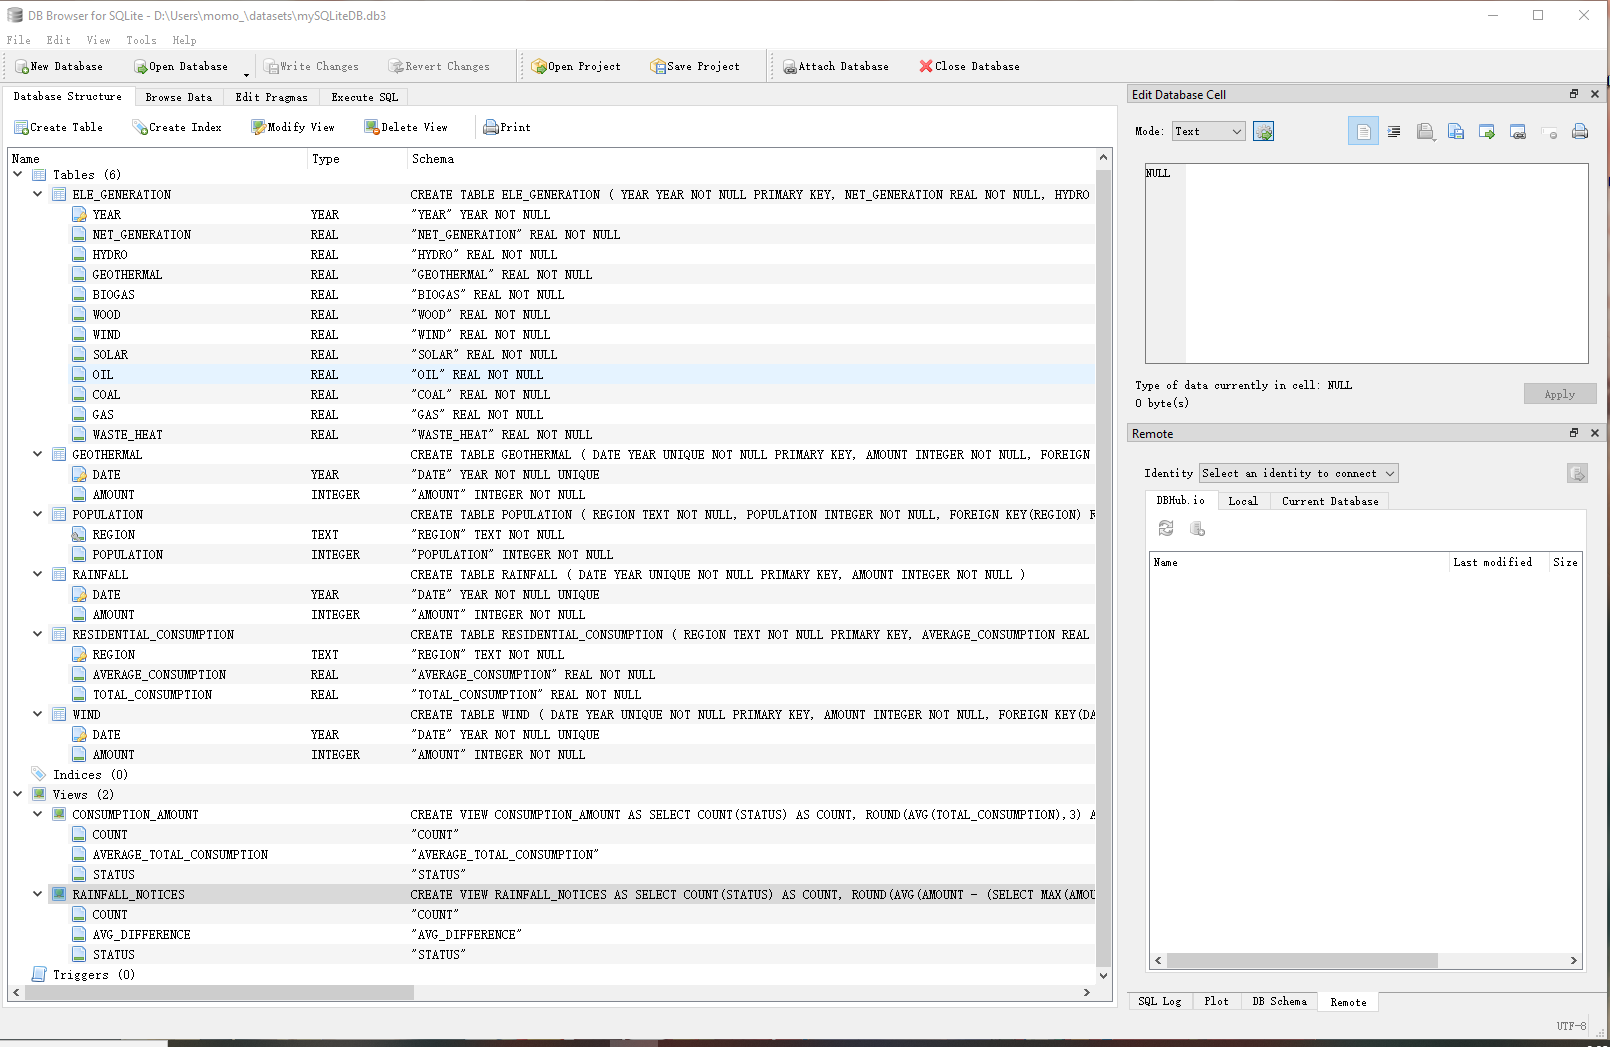

# Access data from databases by using queries

In [24]:
connection=sqlite3.connect('../datasets/mySQLiteDB.db3')

### Transform population table
Process the query to show the number of regions that belong to different statuses according to the size of the population. I set up the population larger than 1 million as a major region; the population greater than 500 thousand and less than 1 million as a large region; the population greater than 100 thousand and less than 500 thousand as a medium region; the population less than 100 thousand as a small region.

In [25]:
sql_statement = """
                SELECT COUNT(REGION) AS NO_OF_REGIONS, 
                AVG(POPULATION) AS AVG_POPULATION,
                CASE WHEN POPULATION >= 1000000 THEN 'Major region'
                    WHEN POPULATION >= 500000 AND POPULATION < 1000000 THEN 'Large region'
                    WHEN POPULATION >= 100000 AND POPULATION < 500000 THEN 'Medium region'
                    ELSE 'Small region' END
                AS STATUS
                FROM POPULATION
                GROUP BY STATUS
                ORDER BY STATUS;
                """
new_population=pd.read_sql_query(sql_statement,connection)
new_population

,NO_OF_REGIONS,AVG_POPULATION,STATUS
0,2,5.939500e+05,Large region
1,1,1.717500e+06,Major region
2,7,2.484857e+05,Medium region
3,5,4.886000e+04,Small region


### Join consumption and population tables
This query prepares for the below visualization.

In [26]:
sql_statement = """
                SELECT rc.REGION, AVERAGE_CONSUMPTION, TOTAL_CONSUMPTION,POPULATION
                FROM RESIDENTIAL_CONSUMPTION AS rc
                INNER JOIN POPULATION AS p
                ON rc.REGION=p.REGION;
                """
residential_table=pd.read_sql_query(sql_statement,connection)
residential_table.head()

,REGION,AVERAGE_CONSUMPTION,TOTAL_CONSUMPTION,POPULATION
0,Auckland,7171.9,3666.3934,1717500
1,Waikato,6837.7,1248.3641,496700
2,Bay of Plenty,6684.9,790.6301,337300
3,Gisborne,6432.4,99.4037,50700
4,Hawke's Bay,7239.9,471.6363,178600


### Find the difference between the rainfall index in each year and maximum rainfall.

In [27]:
sql_statement = """
                SELECT DATE, AMOUNT,
                (SELECT MAX(AMOUNT) FROM RAINFALL) AS "MAXIMUM RAINFALL",
                AMOUNT - (SELECT MAX(AMOUNT) FROM RAINFALL) AS DIFFERENCE
                FROM RAINFALL;
                """
new_rainfall_table=pd.read_sql_query(sql_statement,connection)
new_rainfall_table

,DATE,AMOUNT,MAXIMUM RAINFALL,DIFFERENCE
0,2017,1154,1412,-258
1,2012,1154,1412,-258
2,1999,1154,1412,-258
3,1997,1335,1412,-77
4,1990,1412,1412,0
5,1987,1288,1412,-124
6,1981,1299,1412,-113
7,1976,1335,1412,-77
8,1972,1347,1412,-65
9,1966,1394,1412,-18


### Find the difference between the geothermal production in each year and average geothermal production.

In [28]:
sql_statement = """
                SELECT DATE, AMOUNT,
                (SELECT AVG(AMOUNT) FROM GEOTHERMAL) AS "AVERAGE PRODUCTION",
                AMOUNT - (SELECT AVG(AMOUNT) FROM GEOTHERMAL) AS DIFFERENCE
                FROM GEOTHERMAL;
                """
new_geothermal_table=pd.read_sql_query(sql_statement,connection)
new_geothermal_table.head()

,DATE,AMOUNT,AVERAGE PRODUCTION,DIFFERENCE
0,2019,7.44,6.37,1.07
1,2018,7.51,6.37,1.14
2,2017,7.46,6.37,1.09
3,2016,7.43,6.37,1.06
4,2015,7.41,6.37,1.04


### Find the difference between the wind production in each year and average wind production.

In [29]:
sql_statement = """
                SELECT DATE, AMOUNT,
                (SELECT AVG(AMOUNT) FROM WIND) AS "AVERAGE PRODUCTION",
                AMOUNT - (SELECT AVG(AMOUNT) FROM WIND) AS DIFFERENCE
                FROM WIND;
                """
new_wind_table=pd.read_sql_query(sql_statement,connection)
new_wind_table.head()

,DATE,AMOUNT,AVERAGE PRODUCTION,DIFFERENCE
0,2019,2.22,1.945,0.275
1,2018,2.05,1.945,0.105
2,2017,2.07,1.945,0.125
3,2016,2.31,1.945,0.365
4,2015,2.34,1.945,0.395


### Transform electricity generation table.

In [30]:
sql_statement = """
                SELECT YEAR,
                COAL / NET_GENERATION*100 AS COAL_PERCENTAGE,
                GAS / NET_GENERATION*100 AS GAS_PERCENTAGE,
                OIL / NET_GENERATION*100 AS OIL_PERCENTAGE,
                HYDRO / NET_GENERATION*100 AS HYDRO_PERCENTAGE,
                (GEOTHERMAL+BIOGAS+WIND+SOLAR+WASTE_HEAT) / NET_GENERATION*100 AS RENEWABLE_PERCENTAGE
                FROM ELE_GENERATION;
                """
electricity_generation_table=pd.read_sql_query(sql_statement,connection)
electricity_generation_table.tail()

,YEAR,COAL_PERCENTAGE,GAS_PERCENTAGE,OIL_PERCENTAGE,HYDRO_PERCENTAGE,RENEWABLE_PERCENTAGE
41,2015,4.072989,14.933944,0.003363,56.423387,23.756035
42,2016,2.299153,12.688390,0.007306,60.240150,23.986710
43,2017,2.698739,13.863382,0.013117,58.828688,23.873114
44,2018,3.427957,12.415589,0.025263,60.313149,23.122380
45,2019,4.868599,12.634444,0.009021,58.202735,23.559283


In [31]:
connection.close()

# Data analysis

### Regional situation of New Zealand

Text(0.5,1,'Region status in New Zealand')

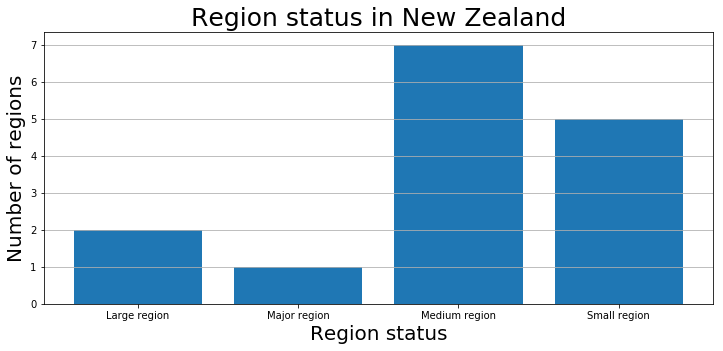

In [32]:
plt.figure(figsize=(12,5))
plt.bar(new_population['STATUS'],new_population['NO_OF_REGIONS'])
ax = plt.gca()
ax.grid(axis='y')
plt.xlabel('Region status',fontsize=20)
plt.ylabel('Number of regions',fontsize=20)
plt.title('Region status in New Zealand',fontsize=25)

The above figure visually describes the regional situation of New Zealand according to the population.

### The difference between geothermal production and the average poduction

Text(0.5,1,'Change of geothermal production in New Zealand')

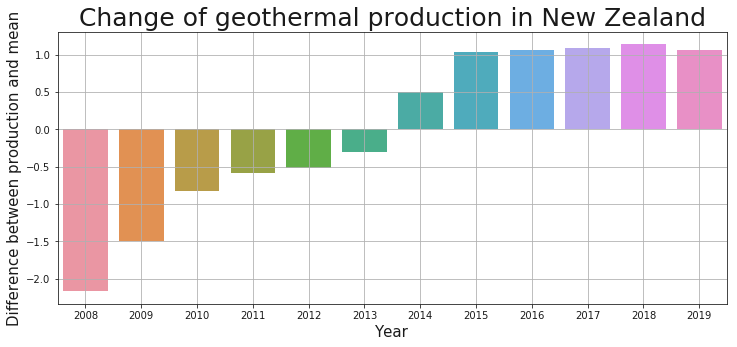

In [33]:
plt.figure(figsize=(12,5))
sns.set_color_codes("muted")
sns.barplot(new_geothermal_table['DATE'],new_geothermal_table['DIFFERENCE'])
ax = plt.gca()
ax.grid(axis='x')
ax.grid(axis='y')
plt.xlabel('Year',fontsize=15)
plt.ylabel('Difference between production and mean',fontsize=15)
plt.title('Change of geothermal production in New Zealand',fontsize=25)

Geothermal production capacity is increasing year by year.

### The difference between wind production and the average poduction

Text(0.5,1,'Change of wind production in New Zealand')

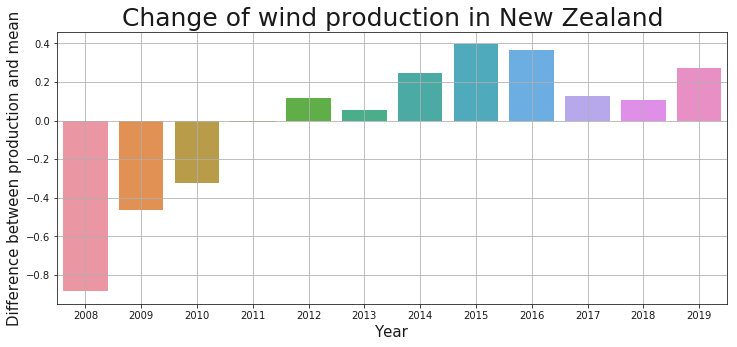

In [34]:
plt.figure(figsize=(12,5))
sns.set_color_codes("muted")
sns.barplot(new_wind_table['DATE'],new_wind_table['DIFFERENCE'])
ax = plt.gca()
ax.grid(axis='x')
ax.grid(axis='y')
plt.xlabel('Year',fontsize=15)
plt.ylabel('Difference between production and mean',fontsize=15)
plt.title('Change of wind production in New Zealand',fontsize=25)

Wind's production capacity has increased in general but fluctuated between 2013 and 2017-2018.

# Database Views

In [35]:
%load_ext sql

In [36]:
%sql sqlite:///../datasets/mySQLiteDB.db3

Residential consumption

In [39]:
%sql DROP VIEW CONSUMPTION_AMOUNT

 * sqlite:///../datasets/mySQLiteDB.db3
Done.


[]

In [40]:
%%sql
CREATE VIEW CONSUMPTION_AMOUNT AS
    SELECT COUNT(STATUS) AS COUNT,
    ROUND(AVG(TOTAL_CONSUMPTION),3) AS AVERAGE_TOTAL_CONSUMPTION,
    STATUS
    FROM (SELECT
             TOTAL_CONSUMPTION,
             CASE WHEN TOTAL_CONSUMPTION >= 3000 THEN 'Large'
             WHEN TOTAL_CONSUMPTION < 3000 AND TOTAL_CONSUMPTION >= 1000 THEN 'Medium'
             ELSE 'Little' END
             AS STATUS
         FROM RESIDENTIAL_CONSUMPTION)
    GROUP BY STATUS

 * sqlite:///../datasets/mySQLiteDB.db3
Done.


[]

In [41]:
%%sql
SELECT * FROM CONSUMPTION_AMOUNT

 * sqlite:///../datasets/mySQLiteDB.db3
Done.


COUNT,AVERAGE_TOTAL_CONSUMPTION,STATUS
1,3666.393,Large
12,366.059,Little
3,1562.43,Medium


Rainfall index

In [42]:
%sql DROP VIEW RAINFALL_NOTICES

 * sqlite:///../datasets/mySQLiteDB.db3
Done.


[]

In [43]:
%%sql
CREATE VIEW RAINFALL_NOTICES AS
    SELECT COUNT(STATUS) AS COUNT,
    ROUND(AVG(AMOUNT - (SELECT MAX(AMOUNT) FROM RAINFALL)),1) AS AVG_DIFFERENCE,
    STATUS
    FROM (SELECT
             AMOUNT,
             CASE WHEN ABS(AMOUNT - (SELECT MAX(AMOUNT) FROM RAINFALL)) <= 150 THEN 'Accepted'
             ELSE 'Attention' END
             AS STATUS
         FROM RAINFALL)
    GROUP BY STATUS

 * sqlite:///../datasets/mySQLiteDB.db3
Done.


[]

In [44]:
%%sql
SELECT * FROM RAINFALL_NOTICES

 * sqlite:///../datasets/mySQLiteDB.db3
Done.


COUNT,AVG_DIFFERENCE,STATUS
7,-67.7,Accepted
3,-258.0,Attention


# Conclusion

Data persistence and data analysis have all been completed.